## Step 1: Put all libraries and packages at top

### Standard imports

In [1]:
# files and system
import os
import sys

In [2]:
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [3]:
# working with images
import cv2
import imageio
import scipy.ndimage
import skimage.transform

import torchvision.transforms as transforms

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchsummary
from tqdm import notebook

### Custom imports

In [5]:
sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

sys.path.insert(0, './notebooks')

In [6]:
sys.path.insert(0, '../models')

# models
from unet import UNet
from unet_attention import UNet_attention

sys.path.insert(0, '../notebooks')

## Step 2: Fix a seed for reproducibility, and choose the DEVICE

In [7]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


## Step 3: Evaluate validation performance (quantitative, full sized images)

### Load model

In [9]:
%ls ../checkpoints

ckpt_UNet_BCELoss_baseline.pth     ckpt_UNet_IoULoss_baseline.pth
ckpt_UNet_IoUBCELoss_baseline.pth  ckpt_UNet_IoULoss_baseline_submitted.pth
ckpt_UNet_IoULoss_attention.pth    README.md
ckpt_UNet_IoULoss_augmented.pth


In [10]:
# model_name = 'UNet_IoULoss_baseline'
# model_name = 'UNet_BCELoss_baseline'
# model_name = 'UNet_IoUBCELoss_baseline'
model_name = 'UNet_IoULoss_augmented'
# model_name = 'UNet_IoULoss_attention'


# submitted
# model_name = 'UNet_IoULoss_baseline_submitted'


# instansiate the model
if model_name == 'UNet_IoULoss_attention':
    model = UNet_attention(channel_in=3, channel_out=1)
else:
    model = UNet(channel_in=3, channel_out=1)

 # load model to DEVICE
model = model.to(DEVICE)

# load best weights and put into the evaluation mode
model.load_state_dict(torch.load(f'../checkpoints/ckpt_{model_name}.pth')['net'])

<All keys matched successfully>

### Print info and Plot learning curves:

In [11]:
history = torch.load(f'../checkpoints/ckpt_{model_name}.pth')

best_epoch = history['epoch']
best_iou = history['iou'].item()

print('Best epoch:', best_epoch)
print(f'Validation IoU:', best_iou)

Best epoch: 54
Validation IoU: 0.7030300498008728


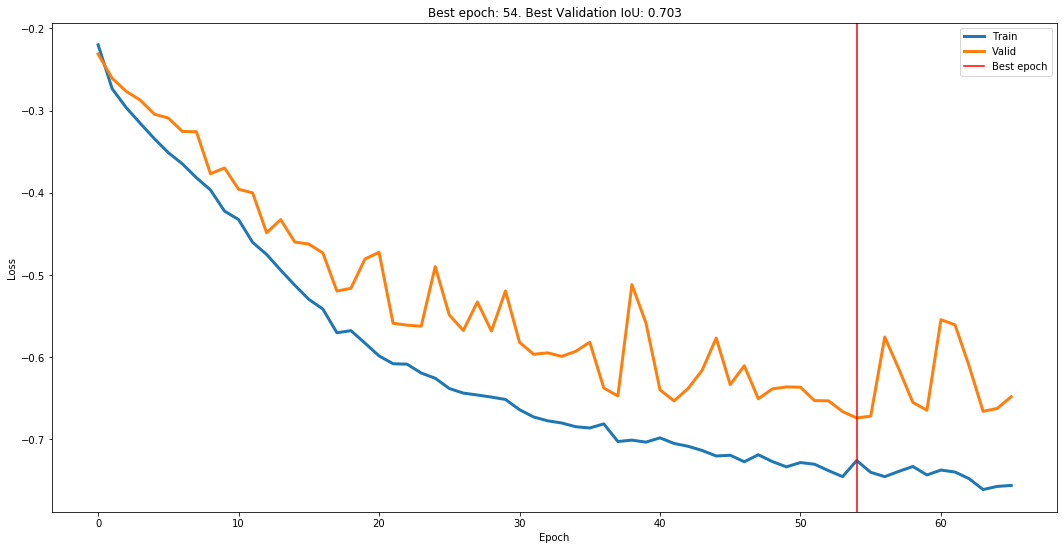

In [12]:
train_losses = history['train_losses']
val_losses = history['val_losses']

# plot
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train', linewidth=3)
plt.plot(np.arange(len(val_losses)), val_losses, label=f'Valid', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Best epoch: {best_epoch}. Best Validation IoU: {best_iou:.4}')
plt.legend(loc='best')

plt.savefig(f"../figures/learning_curves/{model_name}.svg")
plt.show()

### Produce predictions on Validation Set

In [13]:
path_images = "../data/train-val/images"
path_masks = "../data/train-val/masks"

with open('../train-val-split/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]
    
_size = 256, 256
resize = transforms.Resize(_size, interpolation=0)

In [14]:
%mkdir ../predictions_val

mkdir: cannot create directory ‘../predictions_val’: File exists


In [15]:
PRED_PATH = '../predictions_val'
time_taken = []
ious = []
metrics = {}

model.eval() # enter inference/evaluation mode 
for name in notebook.tqdm(ids_val):
    metrics[name] = {} # to record metrics for this particular image
    path_img = os.path.join(path_images, name)
    path_mask = os.path.join(path_masks, name)
    
    img = imageio.imread(path_img) / 255
    mask = imageio.imread(path_mask)[:, :, 0] / 255
    mask = mask.round() # binarize to 0 or 1 
    
    # record shape to revert to 
    H, W, _ = img.shape
    resize_back = transforms.Resize((H, W), interpolation=0)
    
    # convert to Tensors and fix the dimentions (Pytorch uses the channels in the first dimension)
    img = torch.FloatTensor(np.transpose(img, [2, 0 ,1])).unsqueeze(0) 
    mask_binary = torch.FloatTensor(mask).unsqueeze(0)
    
    # resize for the model
    img, mask = resize(img), resize(mask_binary)
    
    # put on the GPU
    img, mask = img.to(DEVICE), mask.to(DEVICE)
    
    # we do not need to calculate gradients
    with torch.no_grad():
        # Start time
        start_time = time.time()
        ## Prediction
        pred = model(img)
        # End timer
        end_time = time.time() - start_time

    time_taken.append(end_time)
    #print("{} - {:.10f}".format(name, end_time))
        
    
    # resize back, nearest interpolation, since it's a mask
    pred = resize_back(pred)
    # put on cpu
    pred = pred.cpu()
    # remove channel => BATCH x H x W
    pred = pred.squeeze(0)
    
    
    # sigmoid, threshold, record score
    ious.append(iou_pytorch_test(pred, mask_binary).item())
        
    metrics[name]['Jaccard'] = iou_pytorch_test(pred, mask_binary).item()
    metrics[name]['DSC'] = dice_pytorch_test(pred, mask_binary).item()
    metrics[name]['Recall'] = recall_pytorch_test(pred, mask_binary).item()
    metrics[name]['Precision'] = precision_pytorch_test(pred, mask_binary).item()
    metrics[name]['F2'] = fbeta_pytorch_test(pred, mask_binary, beta=2.).item()
    metrics[name]['Accuracy'] = accuracy_pytorch_test(pred, mask_binary, ).item()
    
    # comment out if your model contains a sigmoid or equivalent activation layer
    pred = torch.sigmoid(pred)
    # thresholding since that's how we will make predictions on new imputs
    pred = pred > 0.5 
    # remove BATCH => H x W
    pred = pred.squeeze(0)
    # converto to correct type
    pred = pred.numpy().astype(np.float32)
    # revert to standard intensities
    pred = pred * 255.0
    # save
    pred_path = os.path.join(PRED_PATH, name)
    cv2.imwrite(pred_path, pred)


mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("\nmean time taken: ", mean_time_taken)
print("Mean FPS: ", mean_fps)

mean_iou = np.mean(ious)
print("\nMean IoU: ", mean_iou)



mean time taken:  0.0039466957251230875
Mean FPS:  253.37651282170037

Mean IoU:  0.700480333327638


In [16]:
metrics_df = pd.DataFrame(metrics).T.round(5)
metrics_df = metrics_df[['Jaccard', 'DSC', 'Recall', 'Precision', 'Accuracy', 'F2']]
metrics_df = metrics_df.sort_values('Jaccard', ascending=False)
#metrics_df

### Mean Scores

In [17]:
metrics_df.mean(axis=0)

Jaccard      0.700481
DSC          0.786780
Recall       0.830686
Precision    0.843524
Accuracy     0.939053
F2           0.781976
dtype: float64

In [18]:
# for LaTeX table
' & '.join(list(metrics_df.mean(axis=0).round(4).values.astype(str)))

'0.7005 & 0.7868 & 0.8307 & 0.8435 & 0.9391 & 0.782'

## Step 5: Evaluate validation performance (visial, full sized images)

### Best cases

In [19]:
list(metrics_df.head().index)

['cju16ach3m1da0993r1dq3sn2.jpg',
 'cju8dm2cau2km0818jsv9eeq2.jpg',
 'cju85rkbnlo1c08503uxcpax1.jpg',
 'cju87z6o6nh73085045bzsx6o.jpg',
 'cju85omszllp30850b6rm9mi3.jpg']

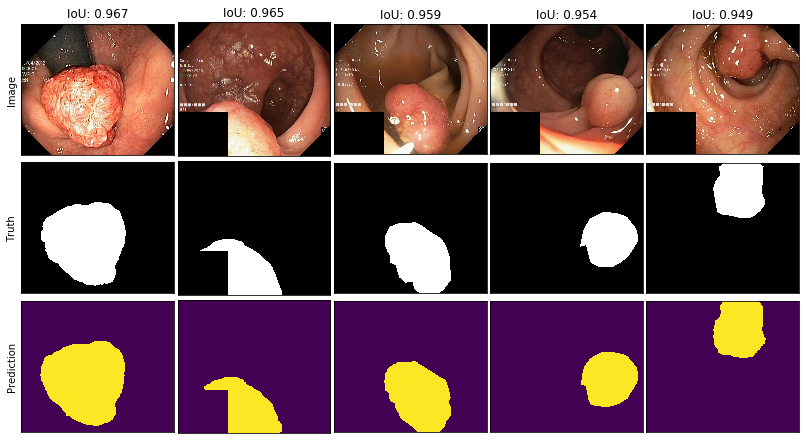

In [20]:
#plt.figure(figsize=(15, 5))
plt.subplots(3, 5, sharex=True, sharey=True, figsize=(11, 6))

for i, name in enumerate(metrics_df.head().index):
    
    plt.subplot(3,5,i+1)
    plt.title(f"IoU: {metrics_df.loc[name]['Jaccard'].round(3)}")
    img = imageio.imread(f'../data/train-val/images/{name}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Image')
    
    plt.subplot(3,5,i+6)
    mask = imageio.imread(f'../data/train-val/masks/{name}')
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Truth')
    
    plt.subplot(3,5,i+11)
    pred = imageio.imread(f'../predictions_val/{name}')
    plt.imshow(pred)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Prediction')
    
    #print(metrics_df.loc[name].round(3))
    #print(80 * '-')


plt.tight_layout(pad=0) # pad=0, w_pad=0, h_pad=0
plt.show()

### Worst cases

In [21]:
list(metrics_df.tail().index)

['cju8chxndsre008015uisl4si.jpg',
 'cju16whaj0e7n0855q7b6cjkm.jpg',
 'cju160wshltz10993i1gmqxbe.jpg',
 'cju87li0zn3yb0817kbwgjiz8.jpg',
 'cju7eea9b2m0z0801ynqv1fqu.jpg']

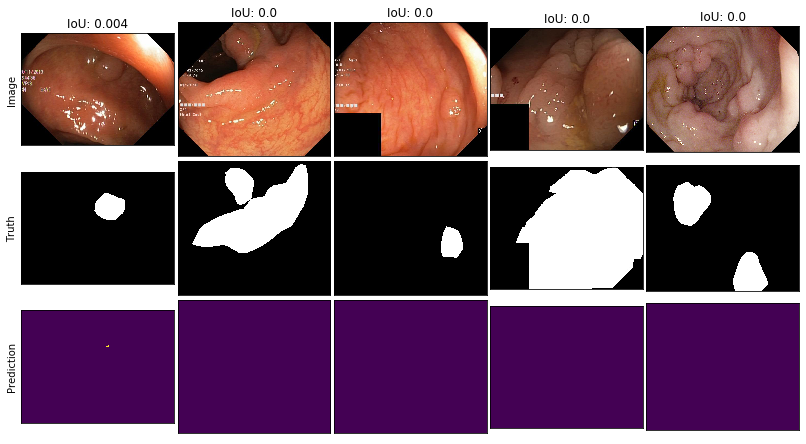

In [22]:
#plt.figure(figsize=(15, 5))
plt.subplots(3, 5, sharex=True, sharey=True, figsize=(11, 6))

for i, name in enumerate(metrics_df.tail().index):
    
    plt.subplot(3,5,i+1)
    plt.title(f"IoU: {metrics_df.loc[name]['Jaccard'].round(3)}")
    img = imageio.imread(f'../data/train-val/images/{name}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Image')
    
    plt.subplot(3,5,i+6)
    mask = imageio.imread(f'../data/train-val/masks/{name}')
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Truth')
    
    plt.subplot(3,5,i+11)
    pred = imageio.imread(f'../predictions_val/{name}')
    plt.imshow(pred)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Prediction')
    
    #print(metrics_df.loc[name].round(3))
    #print(80 * '-')


plt.tight_layout(pad=0) # pad=0, w_pad=0, h_pad=0
plt.show()

### Different cases

cju16ach3m1da0993r1dq3sn2.jpg


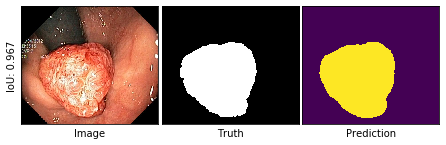

-------------------------------------------------------------------------------- 

cju8dm2cau2km0818jsv9eeq2.jpg


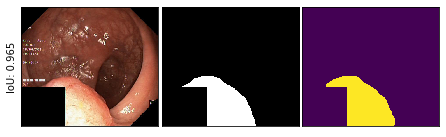

-------------------------------------------------------------------------------- 

cju85rkbnlo1c08503uxcpax1.jpg


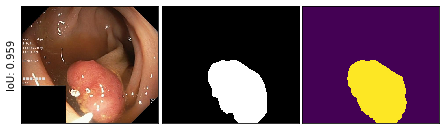

-------------------------------------------------------------------------------- 

cju87z6o6nh73085045bzsx6o.jpg


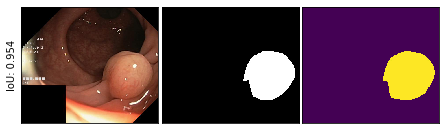

-------------------------------------------------------------------------------- 

cju85omszllp30850b6rm9mi3.jpg


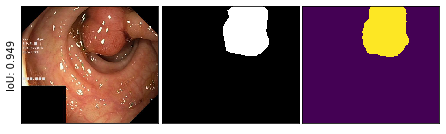

-------------------------------------------------------------------------------- 

cju7dp3dw2k4n0755zhe003ad.jpg


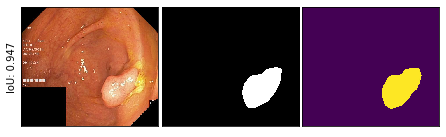

-------------------------------------------------------------------------------- 

cju13fwthn9mq0835gacxgy01.jpg


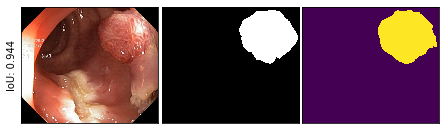

-------------------------------------------------------------------------------- 

cjz14qsk2wci60794un9ozwmw.jpg


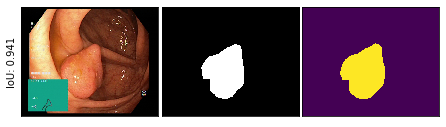

-------------------------------------------------------------------------------- 

cju32srle1xfq083575i3fl75.jpg


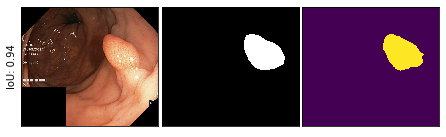

-------------------------------------------------------------------------------- 

cju8cj10qsrau0871o2dr6ai1.jpg


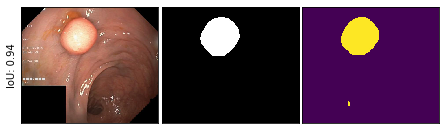

-------------------------------------------------------------------------------- 

cju15wdt3zla10801odjiw7sy.jpg


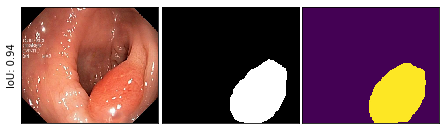

-------------------------------------------------------------------------------- 

cju33w4sdcivk0855x879zht7.jpg


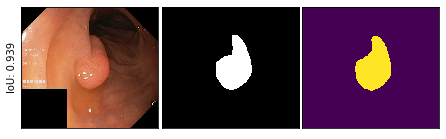

-------------------------------------------------------------------------------- 

cju8dn0c3u2v50801k8rvq02f.jpg


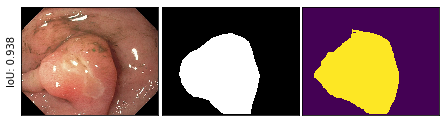

-------------------------------------------------------------------------------- 

cju8dk7eztzup08182yxko5zh.jpg


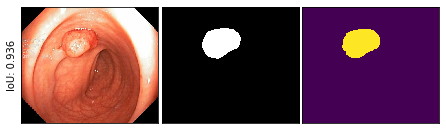

-------------------------------------------------------------------------------- 

cju8dic9mtppa0987swn23wbc.jpg


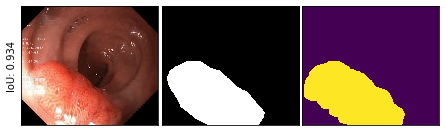

-------------------------------------------------------------------------------- 

cju87tyddnnad0755bj0wxahe.jpg


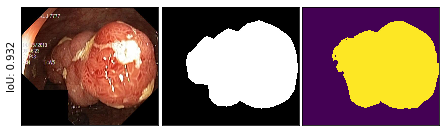

-------------------------------------------------------------------------------- 

cju330ofbc2l30801th5g3hw6.jpg


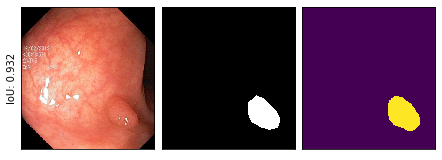

-------------------------------------------------------------------------------- 

cju7ea4om2l910801bohqjccy.jpg


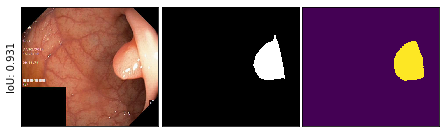

-------------------------------------------------------------------------------- 

cju8ceacrsqkr0755hdz145es.jpg


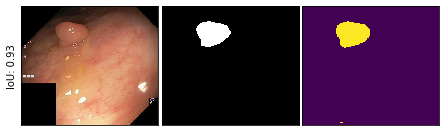

-------------------------------------------------------------------------------- 

cju87r56lnkyp0755hz30leew.jpg


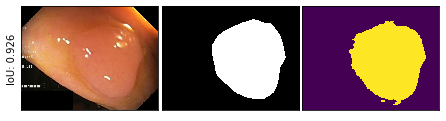

-------------------------------------------------------------------------------- 

cju8d4jgatgpj0871q2ophhkm.jpg


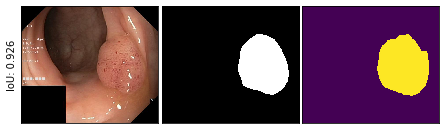

-------------------------------------------------------------------------------- 

cju13cgqmnhwn0988yrainhcp.jpg


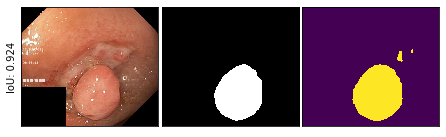

-------------------------------------------------------------------------------- 

cju33o12x2jm50988944mxq0v.jpg


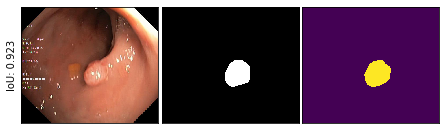

-------------------------------------------------------------------------------- 

ck2395w2mb4vu07480otsu6tw.jpg


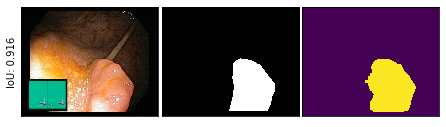

-------------------------------------------------------------------------------- 

cju334jzo261t0835yqudnfs1.jpg


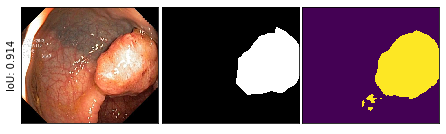

-------------------------------------------------------------------------------- 

cju0u2g7pmnux0801vkk47ivj.jpg


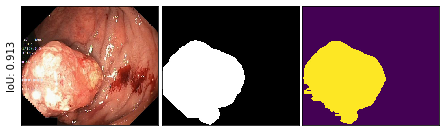

-------------------------------------------------------------------------------- 

cjyzl833ndne80838pzuq6ila.jpg


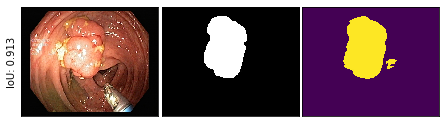

-------------------------------------------------------------------------------- 

cju8chdlqsu620755azjty1tj.jpg


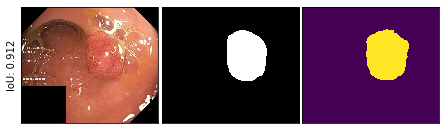

-------------------------------------------------------------------------------- 

cjyzurzvohqnr0794es1itzek.jpg


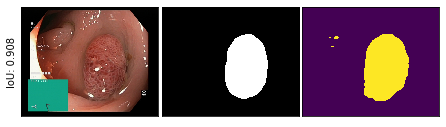

-------------------------------------------------------------------------------- 

cju7dsrtb2f8i085064kwugfk.jpg


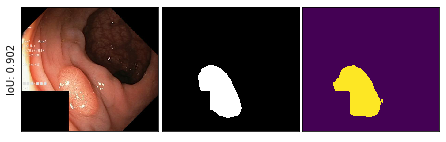

-------------------------------------------------------------------------------- 

cju8dqkrqu83i0818ev74qpxq.jpg


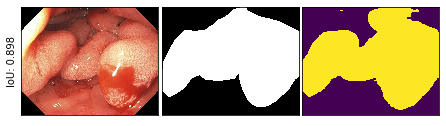

-------------------------------------------------------------------------------- 

cju7dtb1e2j0t0818deq51ib3.jpg


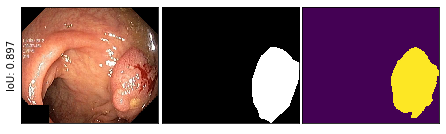

-------------------------------------------------------------------------------- 

cju15czxqp3lv0835jvhgzurz.jpg


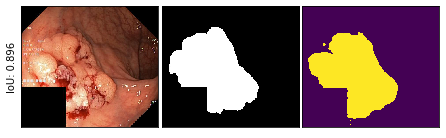

-------------------------------------------------------------------------------- 

cju33qpdvc9g0087825jhf3s9.jpg


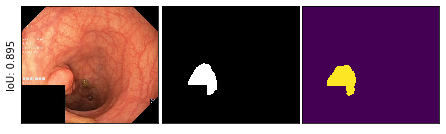

-------------------------------------------------------------------------------- 

cju336l68y7if0993wf092166.jpg


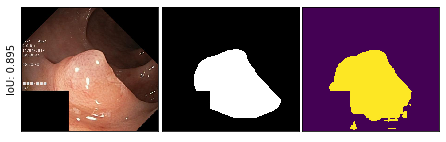

-------------------------------------------------------------------------------- 

cju7dvl5m2n4t0755hlnnjjet.jpg


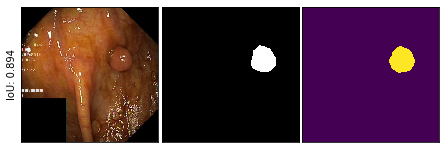

-------------------------------------------------------------------------------- 

cju7dxffn2eam0817qxosfwch.jpg


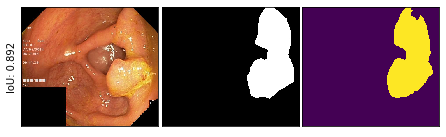

-------------------------------------------------------------------------------- 

cju13hp5rnbjx0835bf0jowgx.jpg


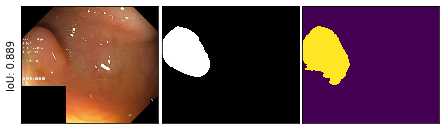

-------------------------------------------------------------------------------- 

cju3381d8bz3h07991xtl7ra0.jpg


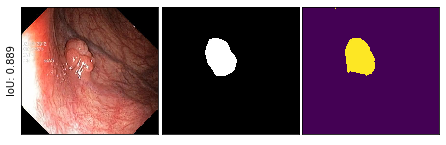

-------------------------------------------------------------------------------- 

cju7dz5yy2i7z0801ausi7rna.jpg


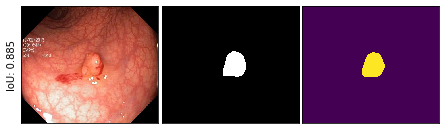

-------------------------------------------------------------------------------- 

cju0t4oil7vzk099370nun5h9.jpg


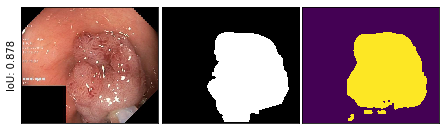

-------------------------------------------------------------------------------- 

cju85plp7lmkw0850rx42jdpf.jpg


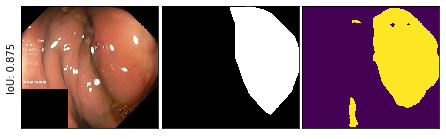

-------------------------------------------------------------------------------- 

cju8828oxnool0801qno9luhr.jpg


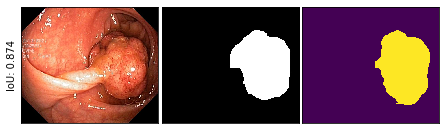

-------------------------------------------------------------------------------- 

ck2da7fwcjfis07218r1rvm95.jpg


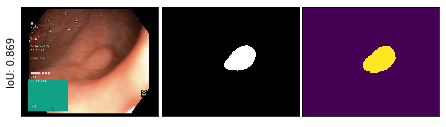

-------------------------------------------------------------------------------- 

cju33belnbyhm0878yxl42233.jpg


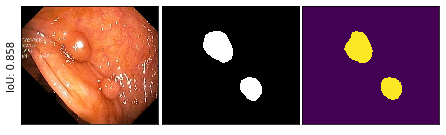

-------------------------------------------------------------------------------- 

cju16b6ynq8e40988m8vx0xnj.jpg


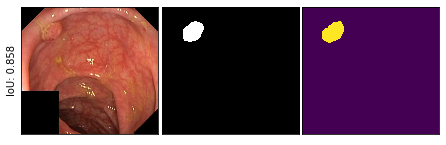

-------------------------------------------------------------------------------- 

cju0ue769mxii08019zqgdbxn.jpg


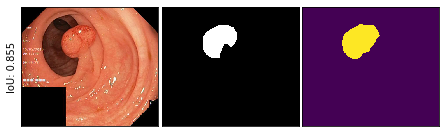

-------------------------------------------------------------------------------- 

cju0u82z3cuma0835wlxrnrjv.jpg


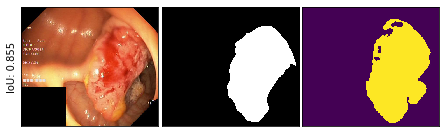

-------------------------------------------------------------------------------- 

cju0s690hkp960855tjuaqvv0.jpg


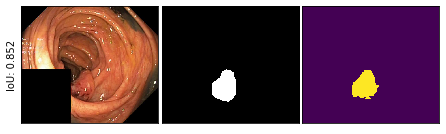

-------------------------------------------------------------------------------- 

cju16jgnyzp970878melv7r25.jpg


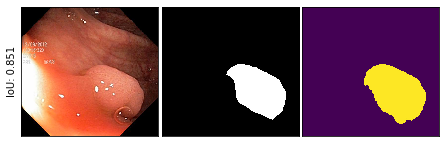

-------------------------------------------------------------------------------- 

cju8cwy02t9eq08185qn12c02.jpg


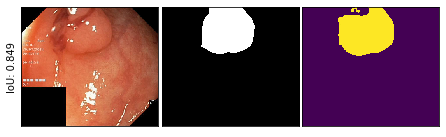

-------------------------------------------------------------------------------- 

cju87q6yoneim0871dl4phvkd.jpg


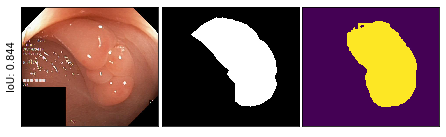

-------------------------------------------------------------------------------- 

cju33x0f22peh0988g0ln7w5v.jpg


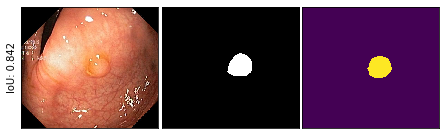

-------------------------------------------------------------------------------- 

cjyztzaqtrv430848l8xgcerw.jpg


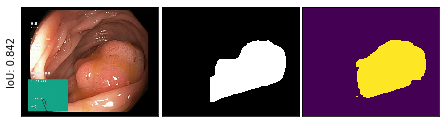

-------------------------------------------------------------------------------- 

cju33mirdc8mj0799k33wzoes.jpg


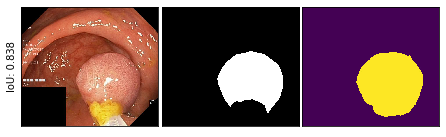

-------------------------------------------------------------------------------- 

cju8czvnztbf40871b4m7t78w.jpg


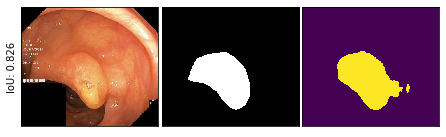

-------------------------------------------------------------------------------- 

cju16d65tzw9d0799ouslsw25.jpg


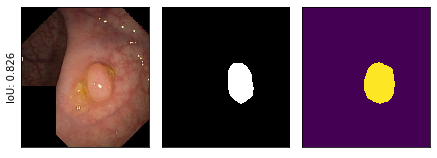

-------------------------------------------------------------------------------- 

cju8djdqztu6408506pzhlo18.jpg


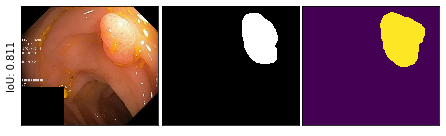

-------------------------------------------------------------------------------- 

cju32upim1z7u0988l883nqp6.jpg


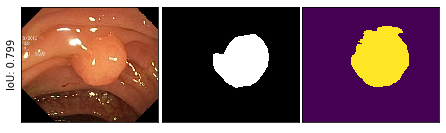

-------------------------------------------------------------------------------- 

cju87mrypnb1e0818scv1mxxg.jpg


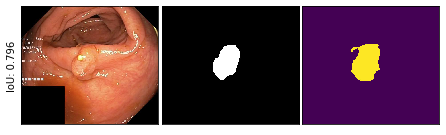

-------------------------------------------------------------------------------- 

cjyzlw7f9faqr070129au64sq.jpg


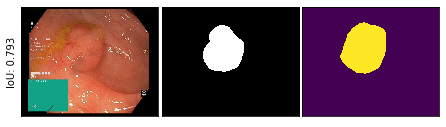

-------------------------------------------------------------------------------- 

cjyzkmjy8evns070165gf9dmq.jpg


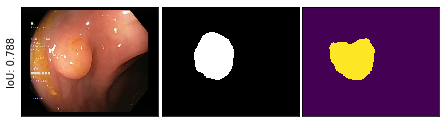

-------------------------------------------------------------------------------- 

cju15ptjtppz40988odsm9azx.jpg


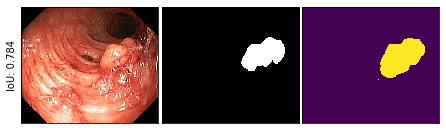

-------------------------------------------------------------------------------- 

cju87zv8lni0o0850hbbecbq6.jpg


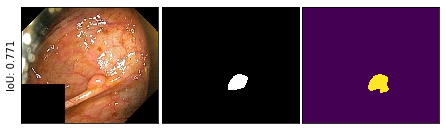

-------------------------------------------------------------------------------- 

cjyzuio1qgh040763k56deohv.jpg


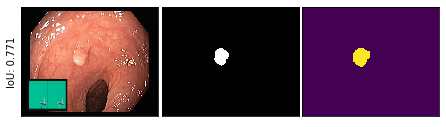

-------------------------------------------------------------------------------- 

ck2bxlujamu330725szlc2jdu.jpg


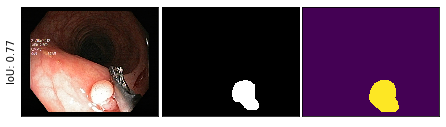

-------------------------------------------------------------------------------- 

cjyzul1qggwwj07216mhiv5sy.jpg


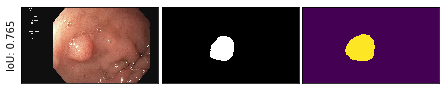

-------------------------------------------------------------------------------- 

cjyzu9th0qt4r0a46pyl4zik0.jpg


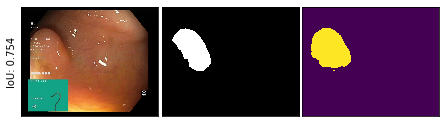

-------------------------------------------------------------------------------- 

cjyzkpsbjdsjq07211dfi4sru.jpg


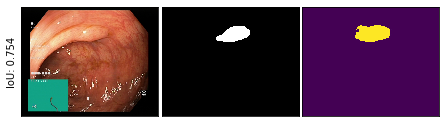

-------------------------------------------------------------------------------- 

cju0vtox5ain6099360pu62rp.jpg


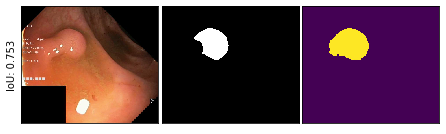

-------------------------------------------------------------------------------- 

cju7ecl9i2i060987xawjp4l0.jpg


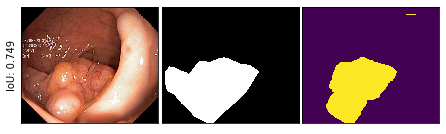

-------------------------------------------------------------------------------- 

cju14hjh2ob2o0835ouz3r5aa.jpg


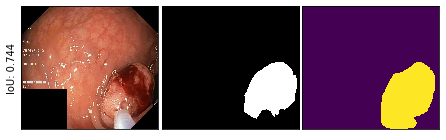

-------------------------------------------------------------------------------- 

cju8clorgsuwn08714toqb7v6.jpg


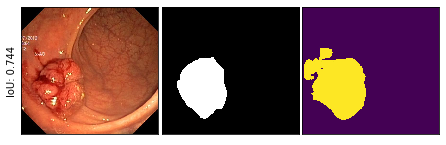

-------------------------------------------------------------------------------- 

ck2bxskgxxzfv08386xkqtqdy.jpg


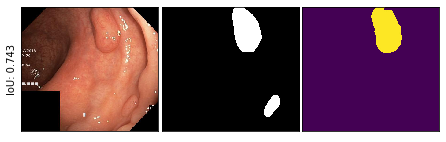

-------------------------------------------------------------------------------- 

cju87xn2snfmv0987sc3d9xnq.jpg


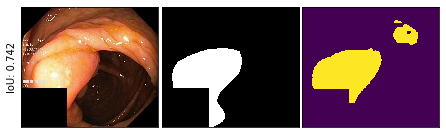

-------------------------------------------------------------------------------- 

cju7dymur2od30755eg8yv2ht.jpg


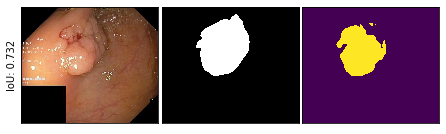

-------------------------------------------------------------------------------- 

cju0sxqiclckk08551ycbwhno.jpg


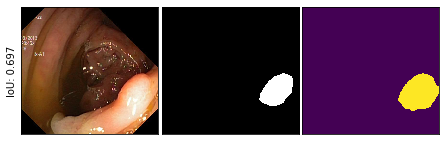

-------------------------------------------------------------------------------- 

cjyzu3reghjya0794w7pwoi50.jpg


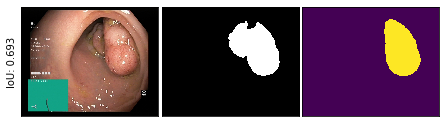

-------------------------------------------------------------------------------- 

cju33jon3ygbj0993pu22a4k6.jpg


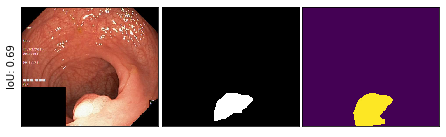

-------------------------------------------------------------------------------- 

cju7druhp2gp308715i6km7be.jpg


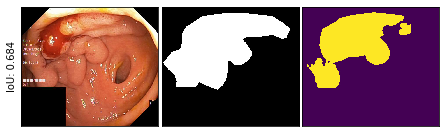

-------------------------------------------------------------------------------- 

cju15jr8jz8sb0855ukmkswkz.jpg


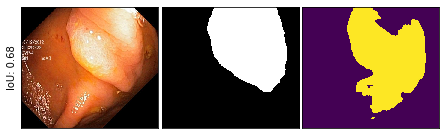

-------------------------------------------------------------------------------- 

cju32zhbnc1oy0801iyv1ix6p.jpg


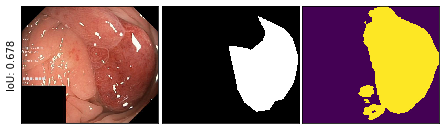

-------------------------------------------------------------------------------- 

cju8d2q30tfhs0801n7lx77xl.jpg


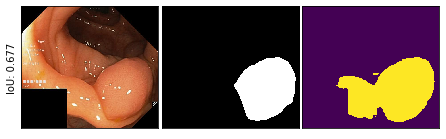

-------------------------------------------------------------------------------- 

cjyzk8qieoboa0848ogj51wwm.jpg


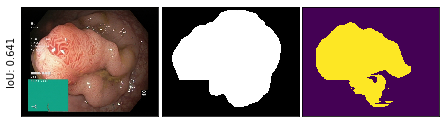

-------------------------------------------------------------------------------- 

cju7ebe962hr409872ovibahw.jpg


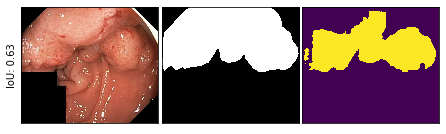

-------------------------------------------------------------------------------- 

cju7dubap2g0w0801fgl42mg9.jpg


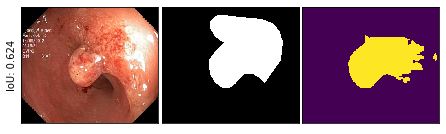

-------------------------------------------------------------------------------- 

cju33231uy4gi0993qc7b1jch.jpg


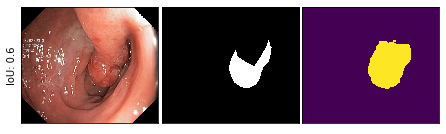

-------------------------------------------------------------------------------- 

cju85qefyln6v0850szeb9byi.jpg


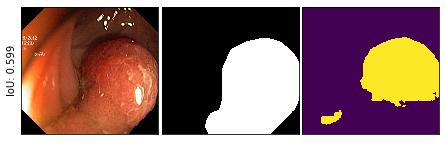

-------------------------------------------------------------------------------- 

cjyzufihqquiw0a46jatrbwln.jpg


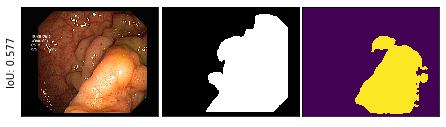

-------------------------------------------------------------------------------- 

cju15mhjczc8z0801kit5c6di.jpg


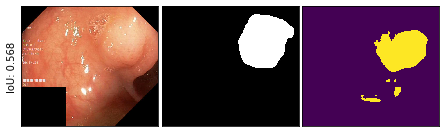

-------------------------------------------------------------------------------- 

cju14g8o4xui30878gkgbrvqj.jpg


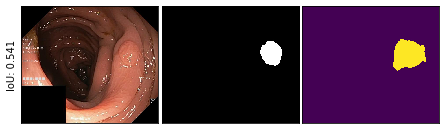

-------------------------------------------------------------------------------- 

cju14pxbaoksp0835qzorx6g6.jpg


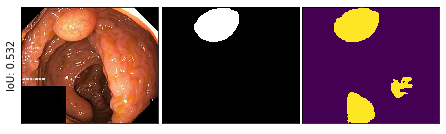

-------------------------------------------------------------------------------- 

cju0sr5ghl0nd08789uzf1raf.jpg


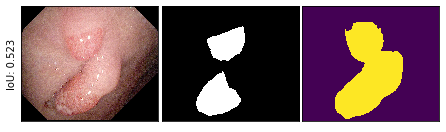

-------------------------------------------------------------------------------- 

cju33eqwbcch208012jikwdky.jpg


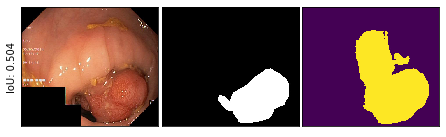

-------------------------------------------------------------------------------- 

cju87vqa0ndwg0850onjdz7ol.jpg


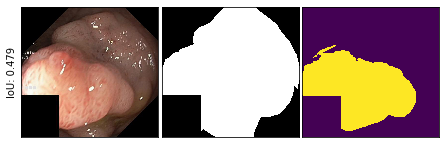

-------------------------------------------------------------------------------- 

ck2bxpfgxu2mk0748gsh7xelu.jpg


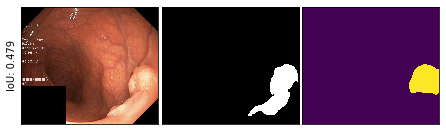

-------------------------------------------------------------------------------- 

ck2bxiswtxuw80838qkisqjwz.jpg


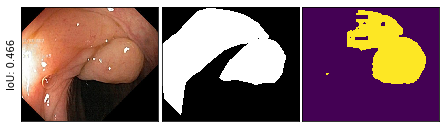

-------------------------------------------------------------------------------- 

cju8dpa89u6l80818dj6lldh9.jpg


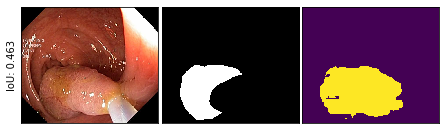

-------------------------------------------------------------------------------- 

ck2bxknhjvs1x0794iogrq49k.jpg


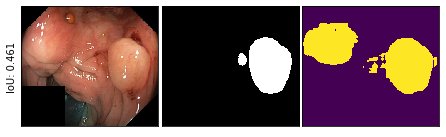

-------------------------------------------------------------------------------- 

cju15l5ubz9yh0855b3ivdpse.jpg


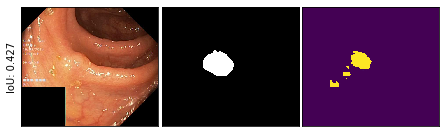

-------------------------------------------------------------------------------- 

cju85nr8elly209872w9n5m0s.jpg


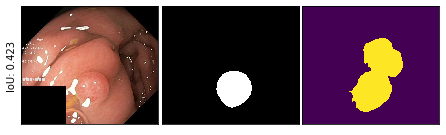

-------------------------------------------------------------------------------- 

cju8doa16u5gh0818w1ywda3q.jpg


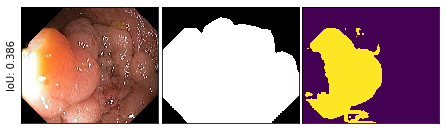

-------------------------------------------------------------------------------- 

cju7dqcwi2dz00850gcmr2ert.jpg


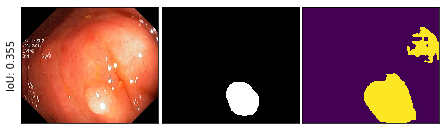

-------------------------------------------------------------------------------- 

cjyzjzssvd8pq0838f4nolj5l.jpg


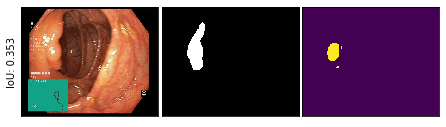

-------------------------------------------------------------------------------- 

cju16fpvhzypl0799p9phnlx6.jpg


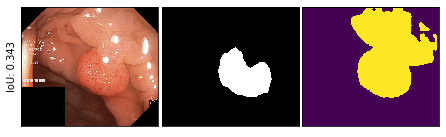

-------------------------------------------------------------------------------- 

cju32qr9tbvsj08013pkpjenq.jpg


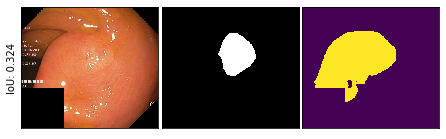

-------------------------------------------------------------------------------- 

cju87nkyrnb970801q84m47yt.jpg


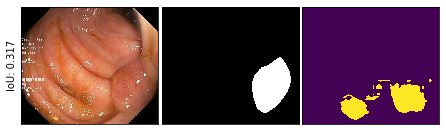

-------------------------------------------------------------------------------- 

ck2bxw18mmz1k0725litqq2mc.jpg


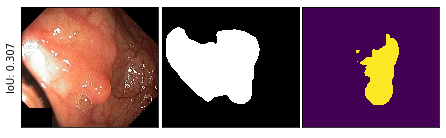

-------------------------------------------------------------------------------- 

cju7dwe282dc309876rco45ts.jpg


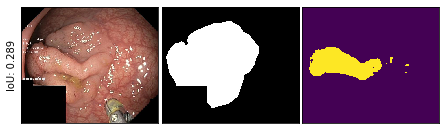

-------------------------------------------------------------------------------- 

cju8cgi2kspp308011nxdtjp6.jpg


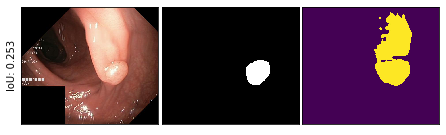

-------------------------------------------------------------------------------- 

cju87ox0kncom0801b98hqnd2.jpg


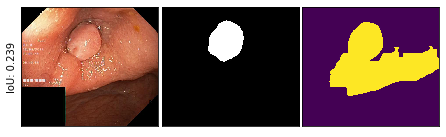

-------------------------------------------------------------------------------- 

cju884985nlmx0817vzpax3y4.jpg


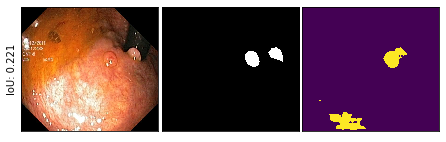

-------------------------------------------------------------------------------- 

cju87kbcen2av0987usezo8kn.jpg


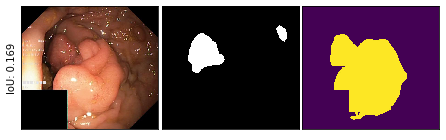

-------------------------------------------------------------------------------- 

ck2bxqz3evvg20794iiyv5v2m.jpg


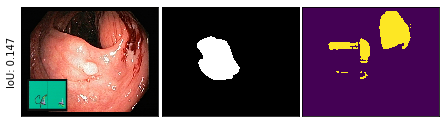

-------------------------------------------------------------------------------- 

cju0tl3uz8blh0993wxvn7ly3.jpg


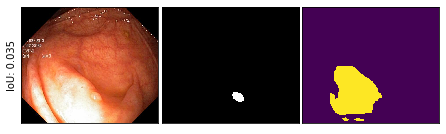

-------------------------------------------------------------------------------- 

cju8chxndsre008015uisl4si.jpg


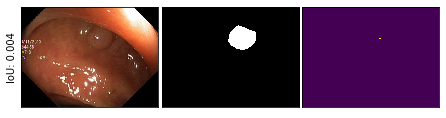

-------------------------------------------------------------------------------- 

cju16whaj0e7n0855q7b6cjkm.jpg


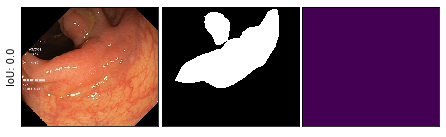

-------------------------------------------------------------------------------- 

cju160wshltz10993i1gmqxbe.jpg


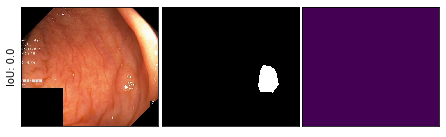

-------------------------------------------------------------------------------- 

cju87li0zn3yb0817kbwgjiz8.jpg


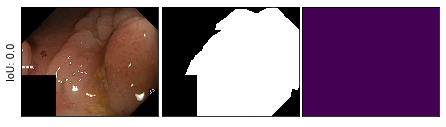

-------------------------------------------------------------------------------- 

cju7eea9b2m0z0801ynqv1fqu.jpg


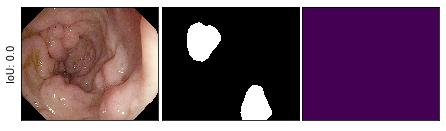

-------------------------------------------------------------------------------- 



In [23]:
#plt.figure(figsize=(15, 5))
for i, name in enumerate(metrics_df.index):
    print(name)
    plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6, 2))
    
    plt.subplot(1,3,1)
    img = imageio.imread(f'../data/train-val/images/{name}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(f"IoU: {metrics_df.loc[name]['Jaccard'].round(3)}")
    if i == 0:
        plt.xlabel('Image')
    
    plt.subplot(1,3,2)
    mask = imageio.imread(f'../data/train-val/masks/{name}')
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.xlabel('Truth')
    
    plt.subplot(1,3,3)
    pred = imageio.imread(f'../predictions_val/{name}')
    plt.imshow(pred)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.xlabel('Prediction')
    

    plt.tight_layout(pad=0) # pad=0, w_pad=0, h_pad=0
    plt.show()
    
    print(80 * '-', '\n')

- fat: cju16ach3m1da0993r1dq3sn2.jpg
- medium: cju85rkbnlo1c08503uxcpax1.jpg
- small: cju8ceacrsqkr0755hdz145es.jpg
- very small: cjyzuio1qgh040763k56deohv.jpg
- flat: cjyzkpsbjdsjq07211dfi4sru.jpg

In [24]:
different_polyp_names = ['cju16ach3m1da0993r1dq3sn2.jpg', 'cju85rkbnlo1c08503uxcpax1.jpg', 'cju8ceacrsqkr0755hdz145es.jpg', 'cjyzuio1qgh040763k56deohv.jpg', 'cjyzkpsbjdsjq07211dfi4sru.jpg']

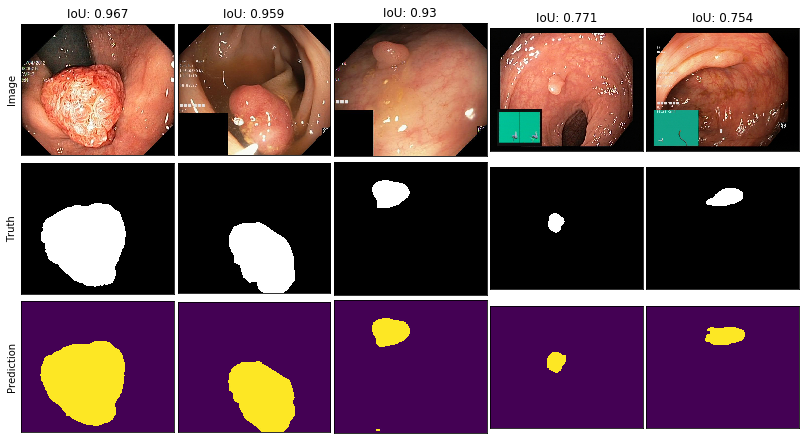

In [25]:
#plt.figure(figsize=(15, 5))
plt.subplots(3, 5, sharex=True, sharey=True, figsize=(11, 6))

for i, name in enumerate(different_polyp_names):
    
    plt.subplot(3,5,i+1)
    plt.title(f"IoU: {metrics_df.loc[name]['Jaccard'].round(3)}")
    img = imageio.imread(f'../data/train-val/images/{name}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Image')
    
    plt.subplot(3,5,i+6)
    mask = imageio.imread(f'../data/train-val/masks/{name}')
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Truth')
    
    plt.subplot(3,5,i+11)
    pred = imageio.imread(f'../predictions_val/{name}')
    plt.imshow(pred)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Prediction')
    
    #print(metrics_df.loc[name].round(3))
    #print(80 * '-')

plt.tight_layout(pad=0) # pad=0, w_pad=0, h_pad=0
#plt.savefig('../figures/validation_examples/different_polyps_img_mask_pred.svg')
plt.show()